# Plot trends in AIRS spectral OLR by month

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load AIRS data

Nearly 20 years of monthly files, so I will work with a single file first.

In [146]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
# airs_files = glob.glob('%s/L3OLR/**.nc' % airs_dir)
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)

airs_files.sort()
# ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [34]:
airs_files

['/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20020901.M01.L3_SpecOLR.std.v06_01_00.M.191116170609.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021001.M01.L3_SpecOLR.std.v06_01_00.M.191116170632.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021101.M01.L3_SpecOLR.std.v06_01_00.M.191116170649.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021201.M01.L3_SpecOLR.std.v06_01_00.M.191116170708.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030101.M01.L3_SpecOLR.std.v06_01_00.M.191116171332.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030201.M01.L3_SpecOLR.std.v06_01_00.M.191116171348.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030301.M01.L3_SpecOLR.std.v06_01_00.M.191116171405.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030401.M01.L3_SpecOLR.std.v06_01_00.M.191116171421.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030501.M01.L3_SpecOLR.std.v06_01_00.M.1911161714

### The single file seems to work appropriately

In [5]:
test_airs = xr.open_dataset(airs_files[0])

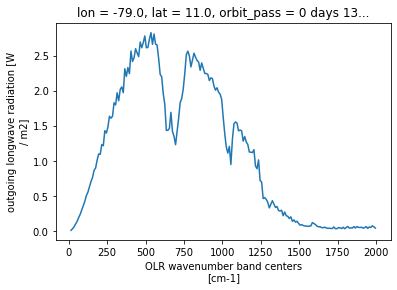

In [8]:
test_airs['olr_spectral'][0,0,:,50,50].plot()

### Create new files with time dimension so that concatenation is possible. Done with and commented.

In [9]:
def add_time_coord(da):
    
    # add appropriate time coordinate from existing coordinate:
    da = da.assign_coords({'time':da['obs_time_tai93'][0].values}).expand_dims('time')
    
    return da

In [10]:
# for i,file_name in enumerate(airs_files):
#     _da = xr.open_dataset(file_name)
    
#     timed = add_time_coord(_da)
#     timed.to_netcdf('%s/proc/%s' % (airs_dir,file_name.split('/')[-1]))
    
#     timed.close()
#     _da.close()
    
#     if i > 10:
#         break

## Open all AIRS files together

In [134]:
# Remove the bad file (masking was being difficult)

# airs_files.pop(69)

'/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20080601.M01.L3_SpecOLR.std.v06_01_00.M.191116173031.nc'

In [147]:
all_airs.close()
all_airs = xr.open_mfdataset(airs_files)

#### Sanity check indicates something wrong in 2008-06 (corrected by removing the bad file or just looking at the Arctic)

It just appears in a single orbit cycle, for two pixels (I think)

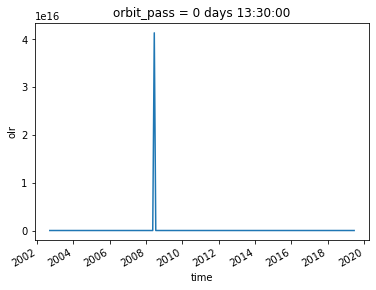

In [148]:
all_airs['olr'][:,0,:,:].mean(dim=['lat','lon']).plot()

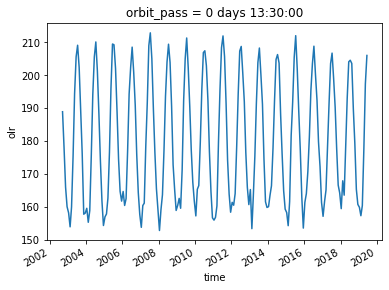

In [150]:
all_airs['olr'][:,0,:,:].sel(lat=slice(70,90)).mean(dim=['lat','lon']).plot()

It appears to be a single pixel, so it should be easy to mask it if I ever want to.

#### Mask bad data in a single file:

In [125]:
bad_file = airs_files[69]
bad_ds = xr.open_dataset(bad_file)

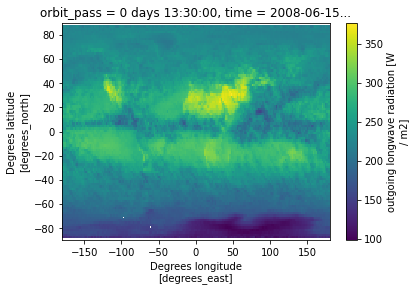

In [117]:
bad_ds['olr'][0,0].where(bad_ds['olr'][0,0] < 1e3,np.nan).plot()

In [118]:
just_bad = bad_ds['olr'][0,0].where(bad_ds['olr'][0,0] > 1e3) #.plot()

Track down the indices of the bad data (there must be an analytic way...). Use drop dims.

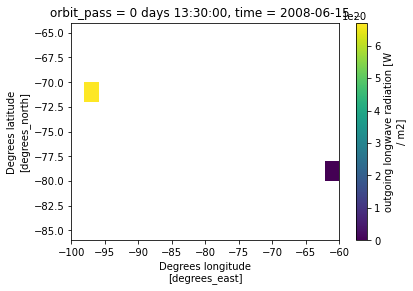

In [119]:
just_bad.sel(lat=slice(-85,-65),lon=slice(-100,-60)).plot()

The bad pixels are located and indices (9,41) and (5,59).

In [122]:
obs_vars = ['olr','olr_clr','olr_spectral','olr_clr_spectral']

#### This doesn't entirely work, but I don't need it for high Arctic calculations.

In [126]:
indx = [[9,41],[5,59]] # indices for values to mask

wasbad_ds = bad_ds.copy()

for i in obs_vars:
    print(i)
    
    # Transpose so I can index correctly
    temp_ds = bad_ds[i].transpose('lat','lon',...)
    
    for j in indx:
        replace = np.nan * np.zeros(temp_ds[j[0],j[1]].shape)
        print(replace.shape)
        temp_ds.load()
        temp_ds[j[0],j[1]] = replace # apply the masked array
    wasbad_ds[i] = temp_ds

olr
(1, 2)
(1, 2)
olr_clr
(1, 2)
(1, 2)
olr_spectral
(1, 2, 199)
(1, 2, 199)
olr_clr_spectral
(1, 2, 199)
(1, 2, 199)


#### Add an absorbed solar radiation variable

In [164]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [154]:
olr_wgt = add_weights(all_airs['olr'])

In [155]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [156]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

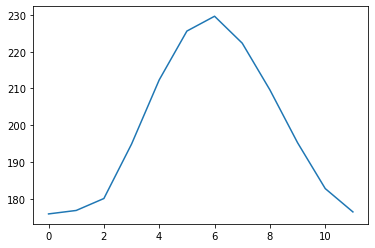

In [157]:
plt.plot(olr_temp)

### Plot a monthly trend

In [158]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

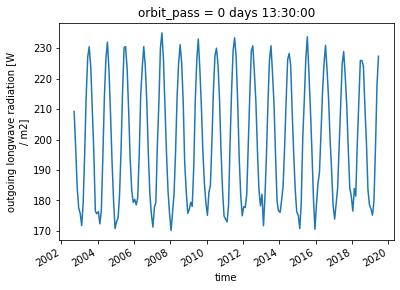

In [161]:
spat_avg[:,0].plot()

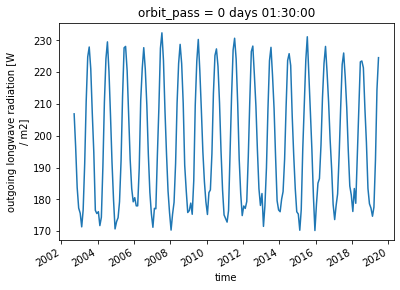

In [162]:
spat_avg[:,1].plot()

In [163]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

Text(0.5, 0.98, 'AIRS OLR (70-90N)')

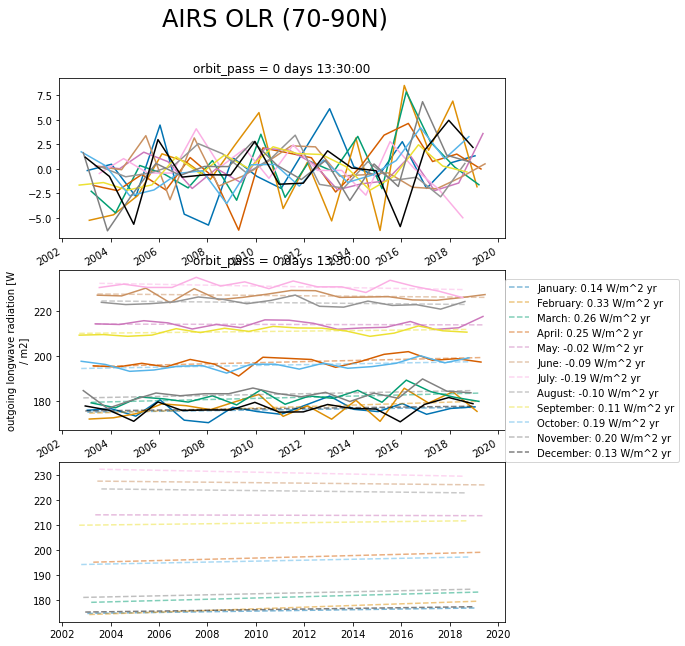

In [172]:
fig,axes = plt.subplots(3,1,figsize=(8,10))


lines=[]
mon_groups = spat_avg[:,0].groupby('time.month') # arbitrary choice of passover time here

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
    label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('AIRS OLR (70-90N)',fontsize=24)

### Package and repeat for other CERES variables

In [167]:
def plot_trends(ds,title):
    '''
    Create the above plot with a single command.
    
    '''
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    
    fig,axes = plt.subplots(3,1,figsize=(8,10))

    lines=[]
    mon_groups = spat_avg.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
        mon_norm = mon - mon.mean() # normalize to the average

        out = regress_1d(mon['time.year'],mon)
        line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
        label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)


        mon_norm.plot(label=label,ax=axes[0],color=color)
        out = mon.plot(label=label,ax=axes[1],color=color)

        axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
        axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)

        lines.append(out)

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)
    

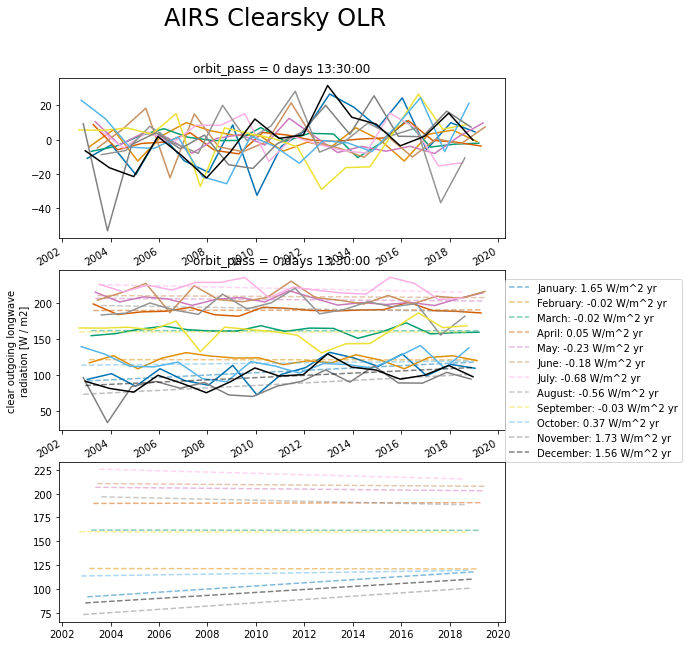

In [171]:
plot_trends(all_airs['olr_clr'][:,0,:,:],'AIRS Clearsky OLR')

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

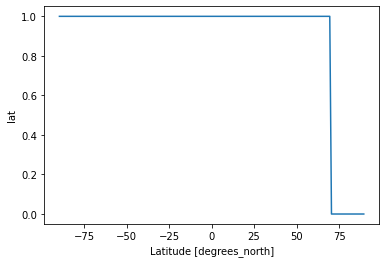

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


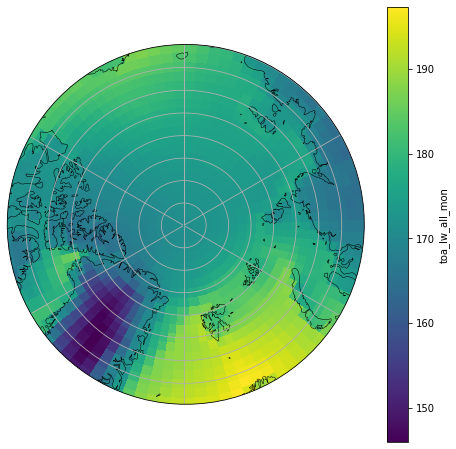

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

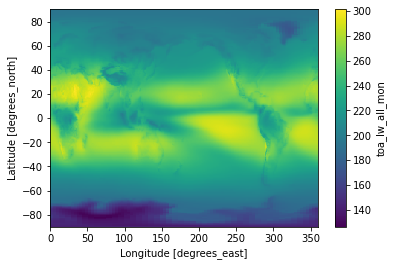

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

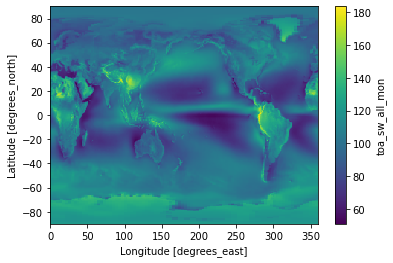

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

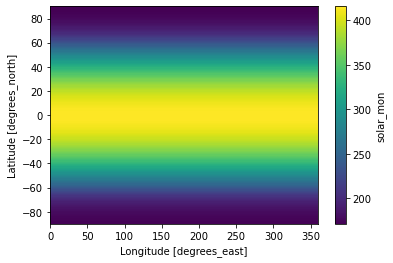

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation